In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [70]:
l = list(tensor.size()[:-1])
a = 3
l.append(a)
l.append(6)
l

[4, 3, 3, 6]

In [76]:
import torch

# Créer un tenseur de dimension (4, 3, 6)
tensor = torch.randn(4, 3, 6)

# Afficher la forme originale
print("Shape originale :", tensor.shape)

a = 3
b = 2
# Reshape vers (4, 3, 3, 2)
new_shape = tensor.shape[:-1]
reshaped_tensor = tensor.view(*new_shape,a,b)

# Afficher la nouvelle forme
print("Nouvelle forme :", reshaped_tensor.shape)


Shape originale : torch.Size([4, 3, 6])
Nouvelle forme : torch.Size([4, 3, 3, 2])


In [4]:
from sklearn.decomposition import PCA
def age_reduction(X: np.array, n_components = 1):
    """
    ACP in age dimension
    Args: 
        X: np.array 3D matrix [i,t,x]
    Returns:
        X_p: np.array 3D matrix [i,t,x'] represents matrix of x'-st ACP components
    """
    X_pca = np.empty((X.shape[0], X.shape[1], n_components))

    for i in range(X.shape[0]):
        pca = PCA(n_components= n_components)
        X_pca[i,:,:] = pca.fit_transform(X[i,:,:])
        print("The variance explained by principal components: ",pca.explained_variance_ratio_)

    return X_pca




from sklearn.cluster import KMeans
def detect_spect_clustering(X: np.array, sigma= 0.2, n_components= 1):
    """
    Algorithms of spectral clustering
    """

    # Sigma représente le compromis de définition de similarité entre deux variables
    country = X.shape[0]
    time = X.shape[1]
    age = X.shape[2]
    X_pca = age_reduction(X, n_components)

    # Initialisation de la matrice d'adjacence
    A = np.array((country,country))
    
    # Calcul de la matrice d'adjacence de taille pour le clustering spectral
    for i in range(country):
        for j in range(country):
            distance = np.mean((X[i,:,:]-X[j,:,:])**2)

            # matrice d'adjacence basée sur la similarité gaussienne
            A[i,j] = np.exp(- distance / (2 * sigma ** 2))
    
    # Matrice de dégrés 
    D = np.diag(np.sum(A, axis=1))

    # Matrice de Laplace non normalisée
    L = D - A

    # Matrice de Laplace normalisée
    L_norm = np.identity(country) - np.dot((D**(-1/2)).dot(A), D**(-1/2))

    # Valeurs propres de L_norm
    eigen_values = list(np.linalg.eigvals(L_norm))
    eigen_values_diff = [(eigen_values[i+1]-eigen_values[i]) for i in range(len(eigen_values))]
    k = eigen_values_diff.index(max(eigen_values_diff))+1 # +1 à cause des index qui commencent par 0 dans python

    # k premiers Vecteurs propres de L_norm
    eigen_vectors = np.linalg.eig(L_norm)[:,0:k]
    # Normalisation sur ligne des vecteurs propres
    eigen_vectors = eigen_vectors / np.sqrt((eigen_vectors**2).sum(axis=1)).reshape(eigen_vectors[0],1)
    
    # k-means sur eigen_vectors
    # Initialiser le modèle K-Means
    kmeans = KMeans(n_clusters=k)

    # Ajuster le modèle aux données
    kmeans.fit(eigen_vectors)
    
    # Prédire les classes de chaque pays
    cluster_pays = kmeans.predict(eigen_vectors)

    return cluster_pays


def adjacency_matrix(X: np.array):
    """
    Returns product of difference matrice
    """


class Graphical_network_layer(nn.Module):
    
    def __init__(self, alpha_initializer= 0.5, beta_initializer=0.5):
        """
        alpha, beta represent the initialisation of the aggregated combination parameters.
        """
        super(Graphical_network_layer, self).__init__()
        self.alpha= nn.Parameter(torch.tensor(alpha_initializer)) # Initialize by alpha_initializer
        self.beta= nn.Parameter(torch.tensor(beta_initializer)) # Initialize by beta_initializer
        #self.lin_without_baises = nn.Linear(in_features, out_features, bias=False)
        #self.lin_with_baises = nn.Linear(in_features, out_features)
        self.w_neigh = None
        self.w_self = None
        self.initialized = False
        self.sigmoid = nn.Sigmoid()

    def normalized_Adj_M(self, A): 
        D = torch.sum(A, dim=1)
        norm_A = A
        for u in range(A.shape[0]):
            for v in range(A.shape[0]):
                norm_A[u,v] = A[u,v] / np.sqrt(D[u]*D[v])

        return torch.tensor(norm_A)
    
    def tensor_2D_3D_product(self, A, B):
        a_size = A.shape
        b_size = B.shape
        C = torch.Tensor(b_size)
        for i in range(a_size[0]):
            for j in range(a_size[1]):
                C[i] += (A[i,j] * B[j])
    
        return C.float()


    def initialize_layers(self, X):
        # Initialisation de la couche linéaire en fonction de la taille de X
        input_size = X.shape[1]
        self.w_neigh = nn.Parameter(torch.randn(input_size,input_size))
        self.w_self = nn.Parameter(torch.randn(input_size,input_size))
        self.initialized = True

    def forward(self, X, A):
        """
        A represents adjacency matrix with country-X-country size and type tensor
        X represents 3D-tensor of mortality [i,t,x'] with x'=1 by default
        """
        # Initialisation de la couche linéaire si elle ne l'est pas encore
        if not self.initialized:
            # Taille de la deuxième dimension (nombre de caractéristiques)
            self.initialize_layers(X)
        
        # Message passing: A @ X (adjacency matrix multiplied by node features)
        A_norm = self.normalized_Adj_M(A)
        agg_1 = self.tensor_2D_3D_product(A_norm, X)
        agg_2 = self.tensor_2D_3D_product(A, X)

        aggregated = self.alpha * agg_1 + self.beta * agg_2
        X = torch.mm(aggregated, self.w_neigh) + torch.mm(X,self.w_self)
        X = self.sigmoid(X)
        return X

class Graphical_network(nn.Module):
    def __init__(self, alpha_initializer= 0.5, beta_initializer=0.5):
        super(Graphical_network, self).__init__()
        self.gnn1 = Graphical_network_layer(alpha_initializer, beta_initializer)
        self.gnn2 = Graphical_network_layer(alpha_initializer, beta_initializer)    

    def forward(self, X, A):
        X = self.gnn1(X, A)
        X = self.gnn2(X, A)

        return X
    


from torch import optim
model = Graphical_network()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


X = torch.randn((6,10))
Y = torch.randn(6,10)
A = torch.rand(6,6)
# Boucle d'entraînement simple
for epoch in range(200):
    # Zéro le gradient
    optimizer.zero_grad()
    
    # Forward pass
    output = model(X, A)
    
    # Calcul de la perte
    loss = criterion(output, Y)
    
    # Backward pass et optimisation
    loss.backward()
    optimizer.step()
    
    # Affichage des informations
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')



/var/folders/30/xs_tpbh920106747lw_q469c0000gn/T/ipykernel_18580/4085585156.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(norm_A)


Epoch [10/100], Loss: 1.0361
Epoch [20/100], Loss: 1.0185
Epoch [30/100], Loss: 1.0017
Epoch [40/100], Loss: 0.9847
Epoch [50/100], Loss: 0.9677
Epoch [60/100], Loss: 0.9537
Epoch [70/100], Loss: 0.9444
Epoch [80/100], Loss: 0.9389
Epoch [90/100], Loss: 0.9359
Epoch [100/100], Loss: 0.9344
Epoch [110/100], Loss: 0.9336
Epoch [120/100], Loss: 0.9332
Epoch [130/100], Loss: 0.9330
Epoch [140/100], Loss: 0.9328
Epoch [150/100], Loss: 0.9328
Epoch [160/100], Loss: 0.9327
Epoch [170/100], Loss: 0.9327
Epoch [180/100], Loss: 0.9327
Epoch [190/100], Loss: 0.9327
Epoch [200/100], Loss: 0.9327


L'idée est de construire un modèle de la forme 
$$ AGGREGATE^{k+1}(u) = \alpha^u \sum_{v \in \mathcal{N}(u)} A(u,v)h^{k}(v) + \beta^u \sum_{v \in \mathcal{N}(u)} \frac{A(u,v)}{\sqrt{D(u)D(v)}}h^{k}(v)$$

Ainsi la fonction UPDATE s'écrira:
$$h^{k+1}(u) = \sigma \bigg( w^u_{self} h^k(u) + w^u_{neigh} AGGREGATE^{k+1}(u) + b^{k+1} \bigg)$$

$$ H^{k+1} = \sigma \bigg( W_{self} H^k + W_{neigh} AGGREGATE^{k+1} + B^{k+1} \bigg)$$
where $W_{self}, ~W_{neigh} \in \mathbb{R}^{I\times I}, ~ B^{k+1}\in \mathbb{R}^{I}$ and $H^k, AGGREGATE^{k+1} \in \mathbb{R}^{I\times d}$, $d = X \times T$

In [309]:
B

tensor([[[5, 4, 4, 1],
         [9, 1, 9, 5],
         [9, 1, 6, 4]],

        [[1, 1, 6, 9],
         [8, 7, 8, 7],
         [8, 7, 4, 8]]])

In [308]:
A

tensor([[[ 9,  7, 12,  9],
         [16,  5, 14, 10],
         [12,  2, 12, 10]],

        [[ 6,  9, 10, 15],
         [16, 10, 17,  8],
         [13, 14, 11, 10]]])

In [307]:
A = torch.randint(1,10,(2,3,4))
B = torch.randint(1,10,(2,3,4))
A += B


In [312]:
torch.Tensor(2,3)

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [342]:
def tensor_2D_3D_product(A, B):
    a_size = A.shape
    b_size = B.shape
    C = torch.Tensor(b_size)
    for i in range(a_size[0]):
        for j in range(a_size[1]):
            C[i] += (A[i,j] * B[j])
    
    return C


In [347]:
A = torch.randint(1,10,(2,2))
B = torch.randint(1,10,(2,3,4))

In [328]:
A[0,0]

tensor(2)

In [333]:
X = A[0,0] * B[0]
Y = A[0,1] * B[1]
X + Y

tensor([[21, 16, 59, 26],
        [70, 23, 79, 11],
        [67, 49, 27, 58]])

In [348]:
A, B

(tensor([[2, 7],
         [2, 7]]),
 tensor([[[7, 8, 5, 8],
          [1, 5, 7, 2],
          [7, 3, 7, 6]],
 
         [[7, 6, 7, 2],
          [3, 4, 9, 7],
          [2, 7, 9, 7]]]))

In [350]:
C = tensor_2D_3D_product(A, B)
C.dtype

torch.float32

In [ ]:
model.w_neigh

Parameter containing:
tensor([[-1.0215,  0.9406,  0.5325,  0.7603, -1.7061, -0.0666, -0.5334, -0.1184,
         -0.4390, -0.5668],
        [-2.0167, -1.4288,  0.4689,  0.7827,  0.3904, -0.1177, -0.2944, -2.2652,
         -1.5410,  0.1456],
        [ 0.6358, -1.7242, -1.8332,  1.3699,  0.3630, -0.0485, -0.8340, -0.2648,
         -0.4839,  1.8691],
        [ 1.0166,  0.2224, -0.9532,  0.9115, -0.2092,  0.7962,  0.4190, -0.1750,
          1.0133, -0.3754],
        [ 0.3442,  1.4845, -0.8245, -0.3521,  0.8521,  1.0635,  0.4402, -1.2162,
         -0.0959,  0.7787],
        [ 1.6827, -0.9134, -0.5215,  0.7092,  0.4168,  0.6913, -0.3979, -0.5652,
         -1.1705,  0.1293],
        [ 1.5185, -0.4296,  0.3522, -0.4759,  0.7800,  0.1448, -0.8917, -0.1077,
         -0.8983, -1.1843],
        [-0.9743,  0.2692, -0.9194, -0.4835,  0.0598, -0.7733, -1.3581, -0.4387,
          0.1597, -0.2327],
        [ 0.8140,  1.7068, -0.5054,  0.1663,  0.8440,  0.2863, -0.7263, -2.2620,
          0.0918, -0.3976

In [283]:
X = torch.randn((6,10))
Y = torch.randn(6,10)
A = torch.rand(6,6)
X.shape
A @ X
#torch.matmul(A,X)


tensor([[-0.1499, -1.5148, -0.1033,  1.3177, -0.0583, -0.3746, -1.3055, -1.3785,
         -1.4097,  0.0832],
        [ 0.4783, -1.8742,  0.3474,  0.4663, -0.8154, -0.9720, -0.2369, -1.4086,
         -2.1426, -0.4109],
        [ 0.1637, -0.6335, -0.6716,  0.8917, -0.2540,  0.0970, -2.0845, -0.5618,
         -0.5229, -0.1319],
        [-0.0792, -0.9863, -0.4801,  1.6137, -1.0998, -0.2113, -2.9309, -1.7056,
         -1.3112, -0.5387],
        [ 0.4894, -1.9175, -0.1980,  0.4472,  0.9603,  0.0459, -2.5977, -1.3449,
         -0.6597, -0.9235],
        [ 0.0896, -1.3882, -0.0709,  0.1615, -0.1670, -0.3998, -2.1164, -0.8646,
         -0.1305,  0.5284]])

In [ ]:
import torch

# Tenseurs 3D avec des dimensions compatibles pour le produit matriciel
A = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])  # Taille (2, 2, 2)
B = torch.tensor([[[9, 10, 11], [12, 13, 14]], [[15, 16, 17], [18, 19, 20]]])  # Taille (2, 2, 3)

# Produit matriciel par lots
C = torch.matmul(A, B)
print(C)


tensor([[[ 33,  36,  39],
         [ 75,  82,  89]],

        [[183, 194, 205],
         [249, 264, 279]]])


In [ ]:
import torch

A = torch.tensor([[1, 2, 3], [4, 5, 6]])
result = torch.sum(A, dim=1)
print(result)


tensor([ 6, 15])


In [ ]:
torch.sum(A,dim=1)

tensor([ 6, 15])

In [ ]:
def normalized_Adj_M(A): 
        D = torch.sum(A, dim=1)
        norm_A = torch.Tensor(A.shape)
        for u in range(A.shape[0]):
            for v in range(A.shape[1]):
                norm_A[u,v] = A[u,v] / np.sqrt(D[u]*D[v])

        return torch.tensor(norm_A)

normalized_Adj_M(A)

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [ ]:
detect_spect_clustering(A)

The variance explained by principal components:  [0.39980585]
The variance explained by principal components:  [0.4246952]
The variance explained by principal components:  [0.30450474]
The variance explained by principal components:  [0.38787823]
The variance explained by principal components:  [0.38436763]
The variance explained by principal components:  [0.33655318]


TypeError: mean() received an invalid combination of arguments - got (out=NoneType, dtype=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [ ]:
B.size[1]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


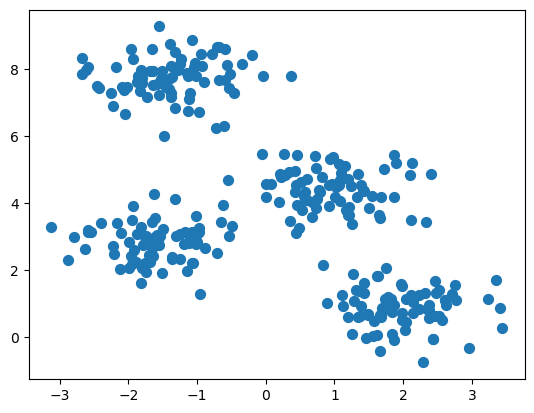

In [ ]:
# Générer des données synthétiques
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Visualiser les données
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()


In [ ]:
# Initialiser le modèle K-Means
kmeans = KMeans(n_clusters=4)

# Ajuster le modèle aux données
kmeans.fit(X)

# Prédire les clusters
y_kmeans = kmeans.predict(X)


In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

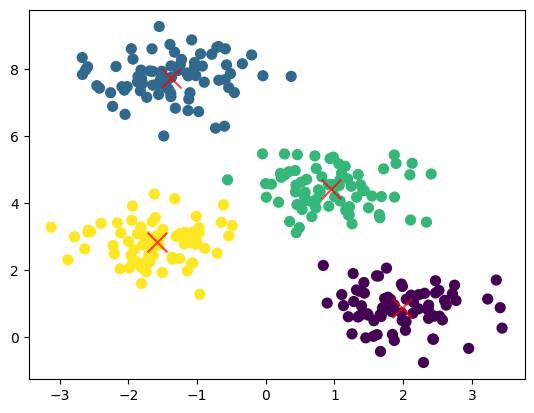

In [ ]:
# Visualiser les clusters
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Visualiser les centres des clusters
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')
plt.show()


In [ ]:
7 / (np.sqrt(49 + 25 + 1))

0.808290376865476

In [ ]:
(A**2).sum(axis=1)
1 / np.sqrt((A**2).sum(axis=1))[2]

0.11547005383792514

In [ ]:
(A**2).sum(axis=1)

array([14, 29, 75])

In [ ]:
np.sqrt((A**2).sum(axis=1)).reshape(3,1)

array([[3.74165739],
       [5.38516481],
       [8.66025404]])

In [ ]:
A / np.sqrt((A**2).sum(axis=1)).reshape(3,1)

array([[0.26726124, 0.53452248, 0.80178373],
       [0.74278135, 0.37139068, 0.55708601],
       [0.80829038, 0.57735027, 0.11547005]])

In [ ]:
A = A = np.array([1,2,3,4,2,3,7,5,1]).reshape((3,3))

In [ ]:
X = [list(range(1,11)),list(range(12,22)),list(range(23,33))]
X = np.array(X).reshape(2,5,3)
age_reduction(X,2 ).shape

The variance explained by principal components:  [0.99855563 0.00144437]
The variance explained by principal components:  [0.99855563 0.00144437]


(2, 5, 2)

In [ ]:
A = [1,2,3]
B = [4,5]
DTW(A,B)

[[0.0e+00 1.0e+10 1.0e+10]
 [1.0e+10 9.0e+00 2.5e+01]
 [1.0e+10 1.3e+01 1.8e+01]
 [1.0e+10 1.4e+01 1.7e+01]]


17.0

In [ ]:
A = np.array([1,2,3,4]).reshape((2,2))
A

array([[1, 2],
       [3, 4]])

In [ ]:
[np.linalg.eigvals(A)]

[array([-0.37228132,  5.37228132])]

In [ ]:
np.full((len(A)+1, len(B)+1), 10**10)

array([[10000000000, 10000000000, 10000000000],
       [10000000000, 10000000000, 10000000000],
       [10000000000, 10000000000, 10000000000],
       [10000000000, 10000000000, 10000000000]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Charger le jeu de données Iris
data = load_iris()
X = data.data  # Les caractéristiques (features)
y = data.target  # Les étiquettes (target)

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.decomposition import PCA

# Initialiser l'ACP et réduire les dimensions à 2 pour la visualisation
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Afficher les proportions de variance expliquée par chaque composante principale
print("Variance expliquée par chaque composante principale:", pca.explained_variance_ratio_)


Variance expliquée par chaque composante principale: [0.72962445 0.22850762 0.03668922]


In [ ]:
X_pca[:,0:2]

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356],
       [-2.36422905, -0.34190802],
       [-2.29938422, -0.59739451],
       [-2.38984217,  0.64683538],
       [-2.07563095,  1.48917752],
       [-2.44402884,  0.0476442 ],
       [-2.23284716,  0.22314807],
       [-2.33464048, -1.11532768],
       [-2.18432817, -0.46901356],
       [-2.1663101 ,  1.04369065],
       [-2.32613087,  0.13307834],
       [-2.2184509 , -0.72867617],
       [-2.6331007 , -0.96150673],
       [-2.1987406 ,  1.86005711],
       [-2.26221453,  2.68628449],
       [-2.2075877 ,  1.48360936],
       [-2.19034951,  0.48883832],
       [-1.898572  ,  1.40501879],
       [-2.34336905,  1.12784938],
       [-1.914323  ,  0.40885571],
       [-2.20701284,  0.92412143],
       [-2.7743447 ,  0.45834367],
       [-1.81866953,  0.08555853],
       [-2.22716331,  0.13725446],
       [-1.95184633, -0.62561859],
       [-2.05115137,  0.24216355],
       [-2.16857717,  0.52714953],
       [-2.13956345,

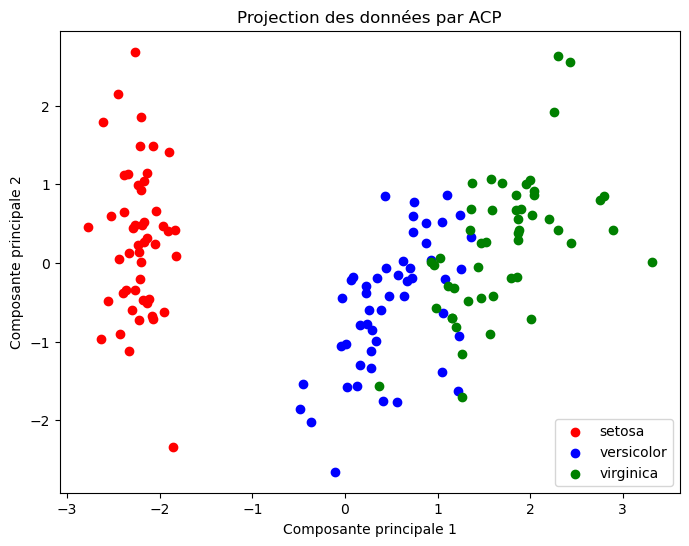

In [ ]:
# Visualiser les données projetées dans l'espace des composantes principales
plt.figure(figsize=(8, 6))
for label, color in zip([0, 1, 2], ['red', 'blue', 'green']):
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=data.target_names[label], color=color)

plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title("Projection des données par ACP")
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearCombinationModel(nn.Module):
    def __init__(self):
        super(LinearCombinationModel, self).__init__()
        # Initialiser alpha et beta comme des paramètres entraînables
        self.alpha = nn.Parameter(torch.tensor(0.5))  # Initialisé à 0.5
        self.beta = nn.Parameter(torch.tensor(0.5))   # Initialisé à 0.5

    def forward(self, A, B):
        # Combinaison linéaire de A et B
        C = self.alpha * A + self.beta * B
        return C


# Initialiser les matrices (exemple avec des matrices 2x2)
A = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
B = torch.tensor([[5.0, 6.0], [7.0, 8.0]])

# Créer une instance du modèle
model = LinearCombinationModel()

# Définir une fonction de perte (par exemple, la MSE pour un exemple simple)
criterion = nn.MSELoss()

# Optimiseur (par exemple, SGD)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Exemple de cible (pour l'entraînement)
target = torch.tensor([[10.0, 14.0], [18.0, 22.0]])

# Boucle d'entraînement simple
for epoch in range(100):
    # Zéro le gradient
    optimizer.zero_grad()
    
    # Forward pass
    output = model(A, B)
    
    # Calcul de la perte
    loss = criterion(output, target)
    
    # Backward pass et optimisation
    loss.backward()
    optimizer.step()
    
    # Affichage des informations
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}, Alpha: {model.alpha.item():.4f}, Beta: {model.beta.item():.4f}')


Epoch [10/100], Loss: 0.7474, Alpha: 1.2359, Beta: 2.0132
Epoch [20/100], Loss: 0.6377, Alpha: 1.3324, Beta: 1.9740
Epoch [30/100], Loss: 0.5441, Alpha: 1.4215, Beta: 1.9379
Epoch [40/100], Loss: 0.4642, Alpha: 1.5037, Beta: 1.9045
Epoch [50/100], Loss: 0.3961, Alpha: 1.5797, Beta: 1.8736
Epoch [60/100], Loss: 0.3380, Alpha: 1.6500, Beta: 1.8451
Epoch [70/100], Loss: 0.2884, Alpha: 1.7148, Beta: 1.8188
Epoch [80/100], Loss: 0.2460, Alpha: 1.7747, Beta: 1.7945
Epoch [90/100], Loss: 0.2099, Alpha: 1.8300, Beta: 1.7720
Epoch [100/100], Loss: 0.1791, Alpha: 1.8812, Beta: 1.7512
